In [1]:
# Import Libraries
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import seaborn as sns
from utils.functions import plot_predictive
from utils.layers import BatchLinear, ModifiedLinear, AnchoredBatch

Our second dataset consists of 300 samples from $y = sin(\pi x) + 0.2 cos(4\pi x) - 0.3x + \epsilon$, where $\epsilon \sim N(0, 0.25)$ and $x \sim N(5, 2.5)$.

In [10]:
np.random.seed(25)
# Create Wiggle Data
X = np.random.normal(loc=5,scale=2.5, size=300)
epsilon = np.random.normal(loc=0,scale=0.25,size=300)
y = np.sin(np.pi*X)+0.2*np.cos(4*np.pi*X)-0.3*X+epsilon
print(X.shape, y.shape)
X = X.reshape(-1, 1)
y = y.reshape(-1,1)
data = np.column_stack((X,y))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset = torch.utils.data.TensorDataset(torch.from_numpy(X.astype(np.float32)).to(device), 
                                         torch.from_numpy(y.astype(np.float32)).to(device))

(300,) (300,)


In [3]:
BATCH_SIZE = 32


# Initialize the dataloaders
dataloader = DataLoader(dataset=dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)


# Check what we've created
print(f"DataLoader: {dataloader}" )
print(f"Length of train_dataloader: {len(dataloader)} batches of {BATCH_SIZE}...")

# Input to the model is (samples/batch size) x batch size
print(f"#Training datasamples/Batch Size: {len(X)}/{BATCH_SIZE}= {len(X)/BATCH_SIZE}")

DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x000002042542C370>
Length of train_dataloader: 10 batches of 32...
#Training datasamples/Batch Size: 300/32= 9.375


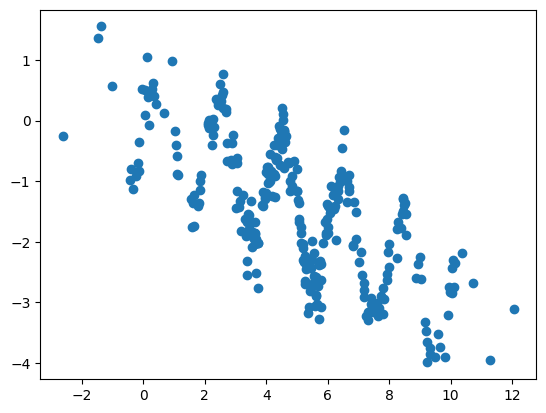

In [4]:
plt.scatter(X,y)

### Use Nicolas BatchEnsemble Code

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, 64)
        self.lin2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.silu(self.lin1(x))
        return self.lin2(x)

torch.manual_seed(0)
models = [Model() for i in range(16)]

(-5.0, 2.0)

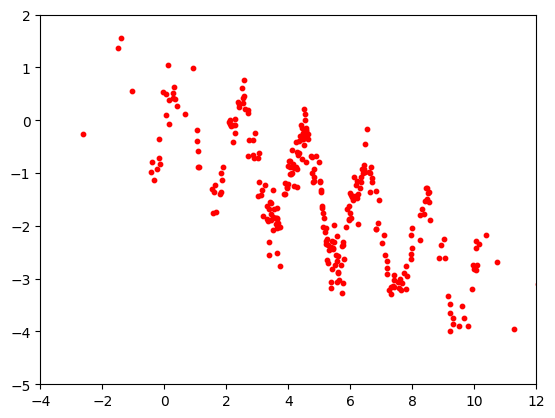

In [6]:
plt.scatter(X, y, c="red", s=10)
plt.xlim(-4, 12)
plt.ylim(-5, 2)

In [8]:
np.random.seed(0)
model_seed = np.random.randint(low=np.iinfo(np.int64).min, high=np.iinfo(np.int64).max, size=len(models), dtype=np.int64)

N = 300
batch_size = 32
n_steps = 20_000
logging_step = n_steps // 5
for i in range(len(models)):
    print(f"training model {i+1}:")
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(models[i].parameters())
    np.random.seed(1)
    for t in range(n_steps):
        idx = np.random.randint(0, N, batch_size)
        X_ = torch.tensor(X[idx, None]).float()
        y_ = torch.tensor(y[idx, None]).float()
    
        y_pred = models[i](X_)
        loss = criterion(y_pred, y_)
        gen = torch.Generator().manual_seed(model_seed[i].item())
        for param in models[i].parameters():
            param = param.ravel()
            prior = 1.0
            eps = torch.randn(param.shape[0], generator=gen) * np.sqrt(prior)
            loss += 1/prior * torch.dot(param - eps, param - eps)
        if t == 0 or t % logging_step == logging_step - 1:
            print(t, loss.item())
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

training model 1:
0 228.1703338623047
3999 2.307076930999756
7999 1.50053071975708
11999 1.8681678771972656
15999 1.6960591077804565
19999 1.5314981937408447
training model 2:
0 240.5450897216797
3999 1.3596760034561157
7999 0.9214509725570679
11999 1.2164634466171265
15999 1.3461295366287231
19999 1.3078539371490479
training model 3:
0 261.5086364746094
3999 1.9025002717971802
7999 0.9003395438194275
11999 0.9209844470024109
15999 1.1256253719329834
19999 1.179115653038025
training model 4:
0 255.4423370361328
3999 3.650452136993408
7999 2.5851738452911377
11999 2.8511669635772705
15999 3.085608959197998
19999 2.921762228012085
training model 5:
0 292.77008056640625
3999 3.64101505279541
7999 2.8103039264678955
11999 3.247197151184082
15999 3.035691738128662
19999 2.613180637359619
training model 6:
0 216.71023559570312
3999 1.515938401222229
7999 0.9741156697273254
11999 1.0304741859436035
15999 1.1837599277496338
19999 1.2417614459991455
training model 7:
0 215.86923217773438
3999 1

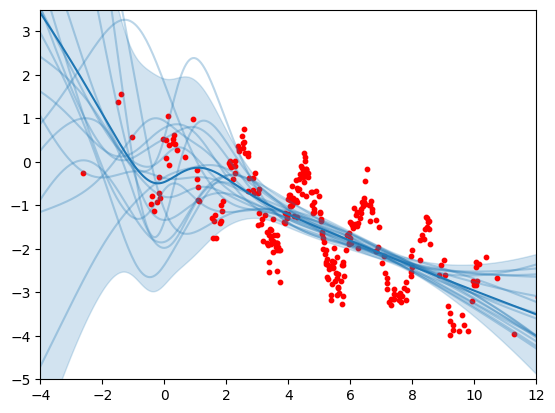

In [9]:
plt.figure()
X_pred = torch.linspace(-4, 12, 300)
y_pred = []
for i in range(len(models)):
    y_pred.append(
        models[i](X_pred.unsqueeze(-1))[:, 0]
    )
y_pred = torch.stack(y_pred, dim=-1)
for i in range(y_pred.shape[-1]):
    plt.plot(
        X_pred.detach().numpy(),
        y_pred[:, i].detach().numpy(),
        color="tab:blue",
        alpha=0.3
    )

y_mean = y_pred.mean(-1).detach().numpy()
y_std = y_pred.std(-1).detach().numpy()
plt.plot(
    X_pred.detach().numpy(),
    y_mean,
    color="tab:blue",
)
plt.fill_between(
    X_pred.detach().numpy(),
    y_mean - 2*y_std,
    y_mean + 2*y_std,
    color="tab:blue",
    alpha=0.2
)
plt.scatter(X, y, c="red", s=10)
plt.xlim(-4, 12)
plt.ylim(-5, 3.5)
plt.show()

### Test a Shallow NN Ensemble

In [33]:
class BaseNN(nn.Module):
        def __init__(self,
                     input_shape:int, 
                     hidden_units: int, 
                     output_shape: int):
            super().__init__()
            self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=1),
        )
        def forward(self, x):
            return self.layer_stack(x)

In [34]:
M = 10 # Number of ensemble members

# Initiate models
NaiveEnsemble = [BaseNN(input_shape=1,hidden_units=128,output_shape=1) for i in range(M)]

In [35]:
# Training Parameters
EPOCHS = 300
# Train each ensemble member
for model in NaiveEnsemble:
    # Initiate Loss function and Optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr= 0.005)
    model.to(device)
    # Conduct training
    for epoch in range(EPOCHS):
        # Training
        train_loss = 0
        # Add a loop to loop through the training batches
        for batch, (input, labels) in enumerate(dataloader):
            model.train()
            # 1. Perform forward pass
            y_pred = model(input) # Make prediction

            # 2. Calculate loss per batch
            loss = loss_function(y_pred, labels) # Calculate loss with MSE

            train_loss += loss.item() # Accumalate loss

            # 3. Optimizer zero grad
            optimizer.zero_grad() # Set the optimizer's gradients to zero

            # 4. Loss backward
            loss.backward()

            #5. Optimizer step
            optimizer.step()
        if epoch%200 == 0:
            print(f"Epoch: {epoch}\n-------")
            print("Loss:", train_loss / (batch + 1))  # Calculate and print average loss per epoch
        
    

Epoch: 0
-------
Loss: 0.8568226516246795
Epoch: 200
-------
Loss: 0.5165474772453308
Epoch: 0
-------
Loss: 0.9094971120357513
Epoch: 200
-------
Loss: 0.5420793831348419
Epoch: 0
-------
Loss: 1.7774866580963136
Epoch: 200
-------
Loss: 0.5319583594799042
Epoch: 0
-------
Loss: 0.7839377403259278
Epoch: 200
-------
Loss: 0.5890250593423844
Epoch: 0
-------
Loss: 1.2719457149505615
Epoch: 200
-------
Loss: 0.5028819888830185
Epoch: 0
-------
Loss: 1.1890802025794982
Epoch: 200
-------
Loss: 0.5489808708429337
Epoch: 0
-------
Loss: 0.960006445646286
Epoch: 200
-------
Loss: 0.5624583929777145
Epoch: 0
-------
Loss: 1.0961864054203034
Epoch: 200
-------
Loss: 0.5277635842561722
Epoch: 0
-------
Loss: 5.6420894205570224
Epoch: 200
-------
Loss: 0.5536198109388352
Epoch: 0
-------
Loss: 2.862526202201843
Epoch: 200
-------
Loss: 0.535891517996788


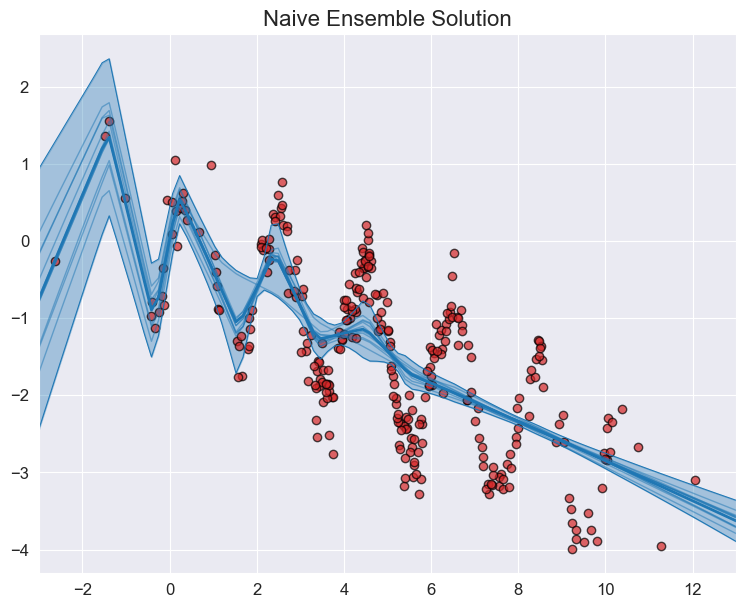

In [37]:
# Plot code from drbayes github
z = np.linspace(-3, 13, 100).reshape(-1,1)
inp = torch.from_numpy(z.astype(np.float32)).to(device)

trajectories = []
for model in NaiveEnsemble:
    out = model(inp).cpu().detach().numpy().T
    trajectories.append(out)
trajectories = np.vstack(trajectories)

plot_predictive(data, trajectories, z.squeeze(), title="Naive Ensemble Solution")

### Test Deep Ensemble
The previous Shallow NN ensemble members had too little complexity to capture the pattern in the data, we'll add some more layers and hidden units to try to find these patterns

In [38]:
class DeepNN(nn.Module):
        def __init__(self,
                     input_shape:int, 
                     hidden_units: int, 
                     output_shape: int):
            super().__init__()
            self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=1)
        )
        def forward(self, x):
            return self.layer_stack(x)

In [39]:
M = 10 # Number of ensemble members

# Initiate models
DeepNaiveEnsemble = [DeepNN(input_shape=1,hidden_units=128,output_shape=1) for i in range(M)]

In [43]:
# Training Parameters
EPOCHS = 800
counter = 0
# Train each ensemble member
for model in DeepNaiveEnsemble:
    counter +=1
    # Initiate Loss function and Optimizer
    print('-'*10,'\n',"Model:",counter, '\n'+'-'*10)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr= 0.005)
    model.to(device)
    # Conduct training
    for epoch in range(EPOCHS):
        # Training
        train_loss = 0
        # Add a loop to loop through the training batches
        for batch, (input, labels) in enumerate(dataloader):
            model.train()
            # 1. Perform forward pass
            y_pred = model(input) # Make prediction

            # 2. Calculate loss per batch
            loss = loss_function(y_pred, labels) # Calculate loss with MSE

            train_loss += loss.item() # Accumalate loss

            # 3. Optimizer zero grad
            optimizer.zero_grad() # Set the optimizer's gradients to zero

            # 4. Loss backward
            loss.backward()

            #5. Optimizer step
            optimizer.step()
        if epoch%100 == 0:
            print(f"Epoch: {epoch}\n-------")
            print("Loss:", train_loss / (batch + 1))  # Calculate and print average loss per epoch
        
    

---------- 
 Model: 1 
----------
Epoch: 0
-------
Loss: 0.22376520186662674
Epoch: 100
-------
Loss: 0.07538573965430259
Epoch: 200
-------
Loss: 0.08893809840083122
Epoch: 300
-------
Loss: 0.11269687339663506
Epoch: 400
-------
Loss: 0.08301380015909672
Epoch: 500
-------
Loss: 0.07386870160698891
Epoch: 600
-------
Loss: 0.09615557193756104
Epoch: 700
-------
Loss: 0.07713401429355145
---------- 
 Model: 2 
----------
Epoch: 0
-------
Loss: 0.1531943164765835
Epoch: 100
-------
Loss: 0.06893843300640583
Epoch: 200
-------
Loss: 0.07922253459692001
Epoch: 300
-------
Loss: 0.08886772915720939
Epoch: 400
-------
Loss: 0.0704563982784748
Epoch: 500
-------
Loss: 0.11199727803468704
Epoch: 600
-------
Loss: 0.06768896207213401
Epoch: 700
-------
Loss: 0.06205978877842426
---------- 
 Model: 3 
----------
Epoch: 0
-------
Loss: 0.1748786024749279
Epoch: 100
-------
Loss: 0.10035184659063816
Epoch: 200
-------
Loss: 0.08520493879914284
Epoch: 300
-------
Loss: 0.0736616536974907
Epoch: 4

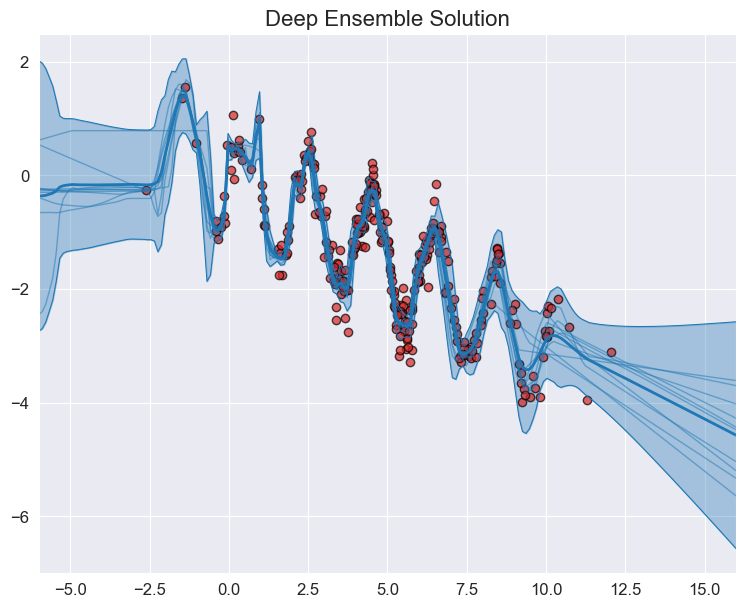

In [49]:
# Plot code from drbayes github
z = np.linspace(-6, 16, 200).reshape(-1,1)
inp = torch.from_numpy(z.astype(np.float32)).to(device)

trajectories = []
for model in DeepNaiveEnsemble:
    out = model(inp).cpu().detach().numpy().T
    trajectories.append(out)
trajectories = np.vstack(trajectories)

plot_predictive(data, trajectories, z.squeeze(), title="Deep Ensemble Solution")

## Anchored Ensemble with Kaiming Normal Initialization

In [4]:
class ModifiedDeepNN(nn.Module):
        def __init__(self,
                     input_shape:int, 
                     hidden_units: int, 
                     output_shape: int):
            super().__init__()
            self.layer_stack = nn.Sequential(
            ModifiedLinear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            ModifiedLinear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            ModifiedLinear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            ModifiedLinear(in_features=hidden_units,
                      out_features=output_shape),
        )
        def forward(self, x):
            return self.layer_stack(x)

In [5]:
M = 10 # Number of ensemble members
n_hidden = 128 # Hidden units in NN
# Initiate models
DeepAnchoredEnsemble = [ModifiedDeepNN(input_shape=1,hidden_units=n_hidden,output_shape=1) for i in range(M)]

In [6]:
mu = 0
data_noise = 0.002
priors = []
taus = []
for layer in DeepAnchoredEnsemble[0].layer_stack.modules():
    # If layer is not activation function, then it has weights
    if hasattr(layer, 'weight'):
        priors.append(layer.std)
        taus.append(data_noise/layer.std)
print("Priors for the different layers:", priors)
print("Tau:", taus)


Priors for the different layers: [0.125, 0.125, 0.125, 1.4142135623730951]
Tau: [0.016, 0.016, 0.016, 0.001414213562373095]


In [7]:
# Training Parameters
EPOCHS = 300
# Train each ensemble member
for model in DeepAnchoredEnsemble:
    theta_anc = []
    for layer, prior in zip(model.layer_stack.modules(),priors):
        # If layer is not activation function, then it has weights
        if hasattr(layer, 'weight'):
            # Check if first layer
            if layer.in_features == 1:
                anc = np.random.normal(loc=mu, scale=prior, size=[n_hidden,1])
            # Check if last layer
            elif layer.out_features == 1:
                anc = np.random.normal(loc=mu, scale=prior, size=[1,n_hidden])
            # Else it is a middle layer
            else: 
                anc = np.random.normal(loc=mu, scale=prior, size=[n_hidden,n_hidden])
        # Convert to tensor
            anc = torch.tensor(anc).float().to(device)
            # Append ensemble member's anchors
            theta_anc.append(anc)

    # Initiate Loss function and Optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr= 0.002)
    # Conduct training
    for epoch in range(EPOCHS):
        # Training
        train_loss = 0
        model.to(device)

        # Add a loop to loop through the training batches
        for batch, (X, y) in enumerate(dataloader):
            N = X.shape[0]
            model.train()
            # 1. Perform forward pass
            y_pred = model(X) # Make prediction

            # 2. Calculate loss per batch
            loss = loss_function(y_pred, y) # Calculate loss with MSE

            reg_term = 0
            # Calculate regularization
            for layer, anchor, tau in zip(model.layer_stack.modules(), theta_anc, taus):
                # If layer is not activation function, then it has weights
                if hasattr(layer, 'weight'):
                    reg_term += 1/N*tau*torch.mul(layer.weight-anchor,layer.weight-anchor).sum()

            #Accumlate loss
            loss += reg_term 
            
            train_loss += loss.item() 
            
            # 3. Optimizer zero grad
            optimizer.zero_grad() # Set the optimizer's gradients to zero

            # 4. Loss backward
            loss.backward()

            #5. Optimizer step
            optimizer.step()
        
        if epoch%50 == 0:
            print(f"Epoch: {epoch}\n-------")
            print("Loss:", train_loss / (batch + 1))  # Calculate and print average loss per epoch

Epoch: 0
-------
Loss: 55.45734901428223
Epoch: 50
-------
Loss: 19.76809196472168
Epoch: 100
-------
Loss: 19.783709144592287
Epoch: 150
-------
Loss: 19.714914512634277
Epoch: 200
-------
Loss: 19.656966781616212
Epoch: 250
-------
Loss: 19.629968452453614
Epoch: 0
-------
Loss: 118.7578519821167
Epoch: 50
-------
Loss: 19.26285400390625
Epoch: 100
-------
Loss: 19.112395095825196
Epoch: 150
-------
Loss: 19.066163635253908
Epoch: 200
-------
Loss: 19.044157409667967
Epoch: 250
-------
Loss: 18.993672561645507
Epoch: 0
-------
Loss: 47.78405990600586
Epoch: 50
-------
Loss: 19.78833122253418
Epoch: 100
-------
Loss: 19.65184955596924
Epoch: 150
-------
Loss: 19.541873741149903
Epoch: 200
-------
Loss: 19.504620170593263
Epoch: 250
-------
Loss: 19.43851089477539
Epoch: 0
-------
Loss: 59.89001903533936
Epoch: 50
-------
Loss: 19.662829208374024
Epoch: 100
-------
Loss: 19.604612159729005
Epoch: 150
-------
Loss: 19.504958724975587
Epoch: 200
-------
Loss: 19.45836982727051
Epoch: 250

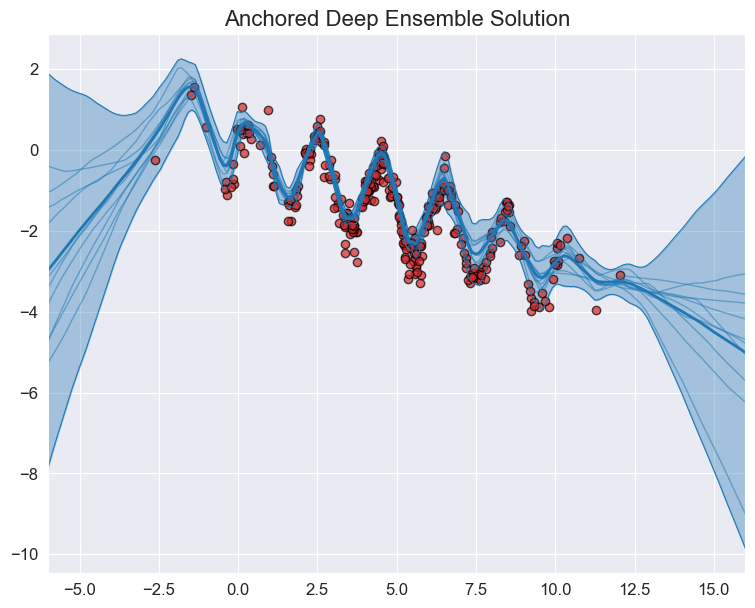

In [12]:
# Plot code from drbayes github
z = np.linspace(-6, 16, 200).reshape(-1,1)
inp = torch.from_numpy(z.astype(np.float32)).to(device)

trajectories = []
for model in DeepAnchoredEnsemble:
    out = model(inp).cpu().detach().numpy().T
    trajectories.append(out)
trajectories = np.vstack(trajectories)

plot_predictive(data, trajectories, z.squeeze(), title="Anchored Deep Ensemble Solution")